In [102]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.base import clone

import plotly.express as px

# Question:
We want to predict whether Indonesia women in 1987 use contraceptive methods or not 


# Helper Function:

In [103]:
def normalize_and_scale(data):
    """
    Centered and scaled the data
    """
    data_centered_scaled = data - np.mean(data,axis=0)
    data_centered_scaled = data_centered_scaled.div(np.std(data_centered_scaled), axis=1)
    return data_centered_scaled

In [104]:
def plot_first_2_pcas(pcas, hue_col):
    """
    Project dataset onto first 2 Principle Components space
    Input:
        pcas: principal components matrix of the data
        hue_col: the column we want the plot's hue to differentiating among
    """
    sns.scatterplot(data = pcas, 
                x = 'pc1', 
                y = 'pc2', 
                hue = hue_col, 
                    palette = "RdBu")
    plt.gca().set_xlim(-10, 10);
    plt.gca().set_ylim(-10, 10);
    plt.title("Projection of Data onto First 2 PCs")

In [105]:
def plot_first_3_pcas(pcas, hue_col):
    """
    Project dataset onto first 3 Principle Components space
    Input:
        pcas: principal components matrix of the data
        hue_col: the column we want the plot's hue to differentiating among
    """
    fig = px.scatter_3d(pcas, 
                    x='pc1', y='pc2', z='pc3', 
                    range_x = [-10, 10], 
                    range_y = [-10, 10], 
                    range_z = [-10, 10], 
                    color = hue_col, 
                    color_continuous_scale = 'RdBu'
                       );
    fig.show();

In [106]:
def set_legend(legend, labs):
    """
    Set given legend object's text to given labels
    """
    for text, lab in zip(legend.texts, labs): 
        text.set_text(lab)

In [107]:
def ohe(data, col_name):
    """
    One Hot Encoding of a specified column in the data
    Input:
        data: the data frame we want to do the one hot encoding 
        col_name: specific column name for OHE (string)
    Output:
        a data frame after applying OHE to the specific column 
    """
    vec_enc = DictVectorizer()
    vec_enc.fit(data[[col_name]].to_dict(orient='records'))
    targeted_col_data = vec_enc.transform(data[[col_name]].to_dict(orient='records')).toarray()
    targeted_col_cats = vec_enc.get_feature_names()
    targeted_col = pd.DataFrame(targeted_col_data, columns=targeted_col_cats)
    data = pd.concat([data, targeted_col], axis=1)
    return data

In [108]:
def plot_confusion_matrix(y_true, y_pred, labels,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input:
        y_true: list, the true label of the test set 
        y_pred: list, the predicted label of the test set 
        labels: list of string, the name for your labels
        normalize: boolean, whether you want a normalized confusion matrix,
                   default is False
        cmap: the color of your confusion matrix plot 
    
    Output:
        the figure of your plot
    ***Reminder: After you have called this fuction, you have called 
        plt.show() to show the plot**
    """
    figure(figsize=(10,10))
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
           xticklabels=labels, 
           title=title,
           ylabel='True label',xlabel='Predicted label')

    # Set tick labels alignment.
    plt.setp(ax.get_xticklabels(), ha="center")
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
    # adjust yticks
    ylabs = labels.copy()
    for i in [0,1,3,4,5]:
        ylabs.insert(i,"")
    ax.set_yticklabels(labels=ylabs, va="center")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[1]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [109]:
def cross_validate_accuracy(model, X, y, k=5):
    """
    run k-folds cross validation using model on X
    Input:
        model: the model to test performance
        X: features matrix, y: target variable
        k: numbers of fold
    Output:
        the average cross validation accuracy 
    """   
    model = clone(model)
    five_fold = KFold(n_splits=k)
    accuracies = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        accuracies.append(model.score(X.iloc[va_ind,:], y.iloc[va_ind]))
    return np.mean(accuracies)

In [110]:
def model_hyper_tune(models, params,X_train, Y_train):
    """
    To tune the hyper paramters 
    Input:
        models: a list of model to try
        params: the list of string of hyper-parameter values we used
        X_train: train data features matrix
        Y_train: train data y value
    Output:
        best_model: the model with the highest cv accuracy
        best_train_accuracy
        best_cv_accuracy
    """
    best_train_accuracy = 0
    best_cv_accuracy = 0
    best_model=clone(models[0]) #default dummy model
    
    for i in range(len(models)):
        cur_model = clone(models[i])
        cur_model.fit(X_train, Y_train)
        model_predicted_train = cur_model.predict(X_train)
        train_accuracy = accuracy_score(Y_train, model_predicted_train)
        cv_accuracy = cross_validate_accuracy(cur_model, X_train, Y_train)
        if(cv_accuracy > best_cv_accuracy):
            best_cv_accuracy = cv_accuracy
            best_train_accuracy = train_accuracy
            best_model = cur_model
            print("Cur model({}); Train Accuracy: {:0.4f}; CV Accuracy: {:0.4f}".format(
                params[i], best_train_accuracy, best_cv_accuracy))
        elif(cv_accuracy == best_cv_accuracy and 
              train_accuracy > best_train_accuracy):
            best_cv_accuracy = cv_accuracy
            best_train_accuracy = train_accuracy
            best_model = cur_model
            print("Cur model({}); Train Accuracy: {:0.4f}; CV Accuracy: {:0.4f}".format(
                params[i], best_train_accuracy, best_cv_accuracy))
        return best_model, best_train_accuracy, best_cv_accuracy

# EDA:

In [111]:
# read in data
data = pd.read_csv("final_proj_data/contraceptive/contraceptive_for_students.csv")

In [112]:
# keep a original copy of data 
ori_data = data.copy()

In [113]:
# check missing values 
data.isna().sum()

wife_age              0
wife_education        0
husband_education     0
num_child             0
wife_religion         0
wife_work             0
husband_occupation    0
standard_living       0
media_exposure        0
contraceptive         0
dtype: int64

From the above result, we conclude that there is no missing values in the dataset. Therefore, we don't have to take extra actions to deal with the missing values.

### Relabeling Reponse 

Since we are only interested in whether the wife used contraceptive method or not, we do not need to differentiate between whether the wife used long-term contraceptive method or short-term contraceptive method. Therefore, we could relabel the `contraceptive` response, i.e. collapsing all the "long-term contraceptive method usage" (`contraceptive=2`) and "short-term contraceptive method usage" (`contraceptive=3`) as "using contraceptive method" (`contraceptive=1`), and relabing "No-use" as `contraceptive=0`.

In [114]:
data['contraceptive'] = data['contraceptive'].replace({1:0, 2: 1, 3: 1})

In [115]:
# train_test_split
X = data.drop('contraceptive', axis=1)
Y = data['contraceptive']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, 
                                                  random_state=110)
print("Training Data Size:", {len(X_train)})
print("Test Data Size:", {len(X_test)})

Training Data Size: {1104}
Test Data Size: {369}


In [116]:
train = X_train.copy()
train['contraceptive_num'] = Y_train
# change to informative labels
train['contraceptive'] = train['contraceptive_num'].replace({0: "No-use", 1:"Use"})

In [117]:
train_centered_scaled = normalize_and_scale(X_train)

We first use PCA to decrease the dimension of our dataset, and visualize the data in 2 or 3 directions that explain the dataset the most

In [118]:
u, s, vt = np.linalg.svd(train_centered_scaled, full_matrices = False)
pcs = train_centered_scaled@vt.T
dat_3_pcs_scaled = pd.DataFrame({'pc1': pcs.iloc[:,0], 'pc2':  pcs.iloc[:,1],
                                     'pc3': pcs.iloc[:,2],
                                    'contraceptive':train['contraceptive']})

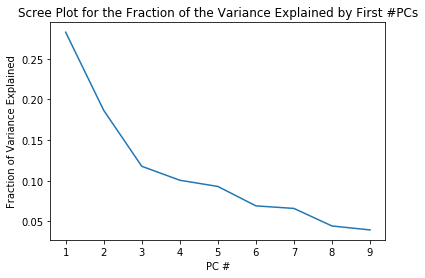

In [119]:
xx = list(range(1, s.shape[0]+1))
plt.plot(xx, s**2 / sum(s**2));
plt.xticks(xx, xx);
plt.xlabel('PC #');
plt.ylabel('Fraction of Variance Explained')
plt.title("Scree Plot for the Fraction of the Variance Explained by First #PCs");

In [120]:
# check the variance explained by first 2 and 3 pcs
variance_explained_by_2_pc = (s[0]**2 + s[1]**2) / np.sum(s**2)
variance_explained_by_3_pc = (s[0]**2 + s[1]**2 + s[2]**2) / np.sum(s**2)
print('Variance explained by first 2 pcs is: {}\nVariance explained by first 3 pcs: {}\n'.format(variance_explained_by_2_pc, 
                                               variance_explained_by_3_pc))

Variance explained by first 2 pcs is: 0.46934244420550725
Variance explained by first 3 pcs: 0.5871859468440358



From the above plot, we observe that the varaince can be mostly explained by the first 3 pcs(principle components). So we will frist visualize our data in the first 2 pcs space, and the first 3 pcs space. 

We color the dataset by their `contraceptive` response.

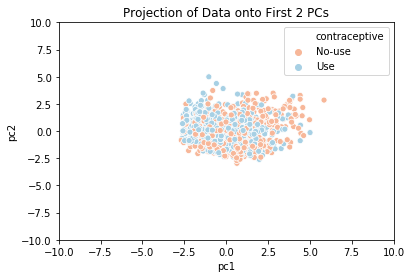

In [121]:
plot_first_2_pcas(dat_3_pcs_scaled, "contraceptive")

In [122]:
plot_first_3_pcas(dat_3_pcs_scaled, "contraceptive")

### Barplots for Qualitative Data

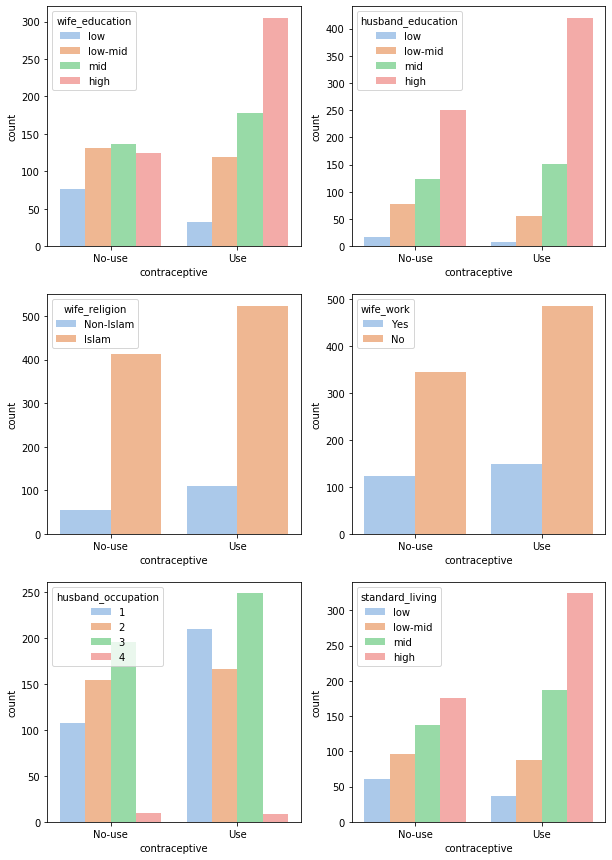

In [123]:
# All qualitative columns we want to plot out 
# Note this is everything besides `wife_age` and `num_child`
col_names = list(X_train.columns.values)[1:]
# remove `num_child` column
col_names.pop(2)
labels_dic = {"wife_education":["low","low-mid","mid","high"],
         "husband_education":["low","low-mid","mid","high"],
         "wife_religion":["Non-Islam","Islam"],
         "wife_work":["Yes","No"],
          "standard_living":["low","low-mid","mid","high"]
         }
k = 2
fig, axes = plt.subplots(int(np.ceil((len(col_names) - 1)/k)), k, figsize=(10,15))
for i in range(0, len(col_names) - 1):
    sns.catplot(x="contraceptive", hue=col_names[i], kind="count",
            palette="pastel", 
            data=train, ax=axes[i//k,i%k], legend_out = True)
    if(col_names[i] in labels_dic):
        cur_lab = labels_dic[col_names[i]]
        l = axes[i//k,i%k].get_legend()
        set_legend(l, cur_lab)
# closed all extra figure
for i in range(0, len(col_names) - 1):
    plt.close(i+2)

plt.show()

<Figure size 720x1080 with 0 Axes>

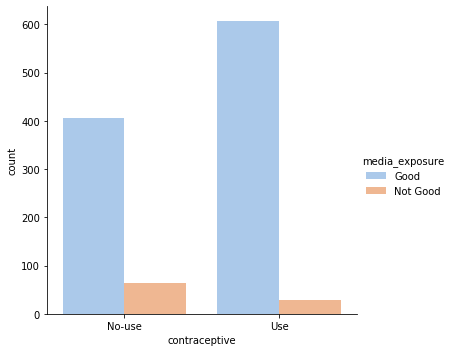

In [125]:
plt.figure(figsize=(10,15))
labels = ['Good', "Not Good"]
fig = sns.catplot(x="contraceptive", hue=col_names[-1], 
            kind="count",palette="pastel", 
            data=train, legend_out = True)

set_legend(fig._legend, labels)

### Heatmap

Here we want to further explore the correlation of `contraceptive` to other varaibles in the dataset

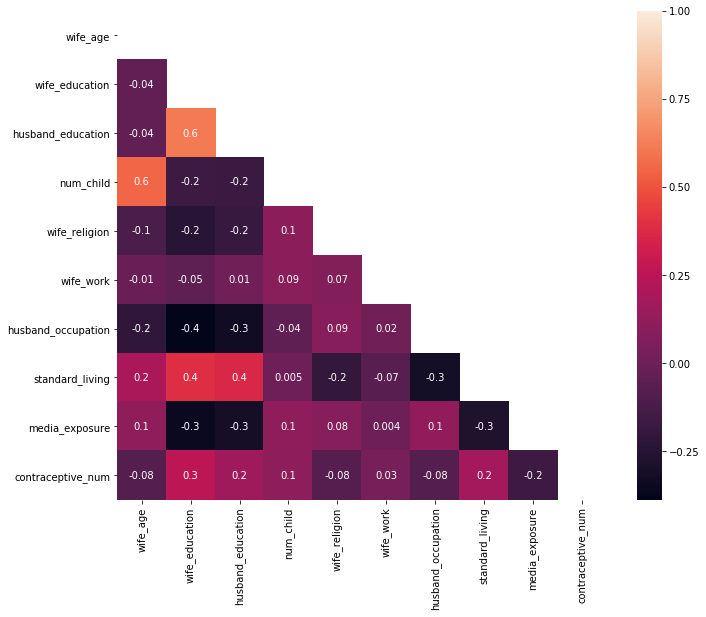

In [126]:
plt.figure(figsize=(11, 9))
matrix = np.triu(train.corr())
ax=sns.heatmap(train.corr(), annot = True, fmt='.1g',square=True, mask=matrix)
ax.set_ylim(10, 0) # set the ylim to bottom, top
plt.savefig('heatmap.png')

From the above heatmap, we observe that `contraceptive` doesn't have too strong relationship with any of the current features. The highest correlation is with `wife_education`, which is 0.3. This is still a weak correlation. We also notice that `wife_age`, `wife_religion`, and `husband_occupation` extremly weakly negatively correlated with `contraceptive`. Therefore, it may be a good choice to either drop these features or transformed them in some way. 

### Boxplots for Quantitative Discrete Varaibles

Here we want to draw the box plots for quantitative featrues to explore their distributions.

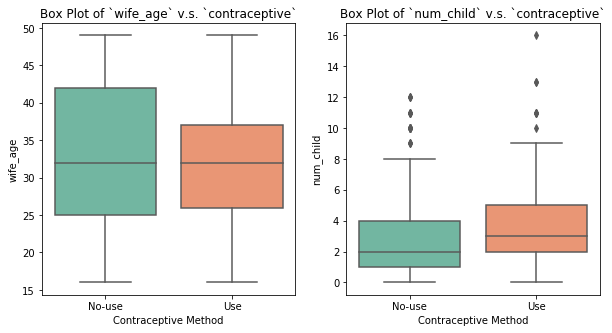

In [25]:
fig1, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x="contraceptive", y="wife_age", data=train,
    palette="Set2",ax=axes[0]).set(
    xlabel="Contraceptive Method")
axes[0].set_title('Box Plot of `wife_age` v.s. `contraceptive`')

sns.boxplot(x="contraceptive", y='num_child', data=train,
    palette="Set2",ax=axes[1]).set(
    xlabel="Contraceptive Method")
axes[1].set_title('Box Plot of `num_child` v.s. `contraceptive`')

plt.show()

### Empirical Distribution: `wife_age`

From previous heatmap, we observe that `wife_age` has a extremely weak negative correlation with `contraceptive`, we want to explore why it's the case. First, we will plot out the empirical distribution of `wife_age` to visualize the data shape, and whether the shape is different between 2 different `contraceptive` groups.

(Note: Since the bin width for `wife_age` is 1, which is way smaller than the range of `wife_age`, to better visualize the distribution, we choose to keep `kde` parameter of `distplot`, and approximetaly draw its distribution plot below.)

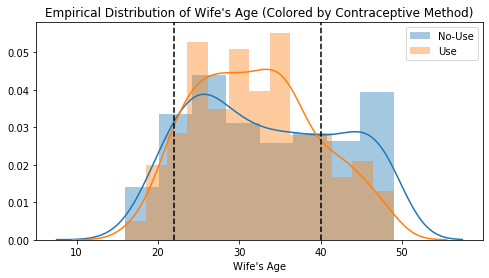

In [26]:
# wife_age distribution plot
plt.figure(figsize=(8, 4))
sns.distplot(train.loc[(train["contraceptive_num"]==0) , "wife_age"])
sns.distplot(train.loc[(train["contraceptive_num"]==1) , "wife_age"])
plt.xlabel("Wife's Age")
plt.title("Empirical Distribution of Wife's Age (Colored by Contraceptive Method)")
plt.legend(labels=["No-Use", "Use"]) 
plt.axvline(22, color='k', linestyle='dashed')
plt.axvline(40, color='k', linestyle='dashed')
plt.show();

### Suggested Transformation: `wife_age`
Larger values of `wife_age` will carry larger weights in the model, and it could hurt the model's performance. We could use the following 2 methods to transform the `wife_age`.
##### Method 1: 
From the above distribution, we observe that the data could be split into 3 age bins according to their difference between the 2 age groups.
1. age <= 22; 
2. 22 < age < 40; 
3. age >= 40;

After changing the quantitative discrete data to categorical data, we could use one-hot-encoding to create three new features for age. Also from the above graph, we observe that the empirical distribution are similar between 2 contraceptive method groups when the wife's age <= 22. So, we predict that dropping the feature associated with whether wife's age <= 22 could potentially be helpful.
##### Method 2:
Normalized `wife_age`

### Empirical Distribution: `num_child`

(Note: Since the bin width for `num_child` is 1, which is way smaller than the range of `num_child`, to better visualize the distribution, we choose to keep `kde` parameter of `distplot`, and approximetaly draw its distribution plot below.)

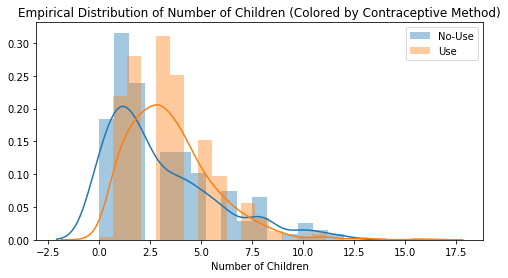

In [27]:
plt.figure(figsize=(8, 4))
sns.distplot(train.loc[(train["contraceptive_num"]==0) , "num_child"])
sns.distplot(train.loc[(train["contraceptive_num"]==1) , "num_child"])
plt.xlabel("Number of Children")
plt.title("Empirical Distribution of Number of Children (Colored by Contraceptive Method)")
plt.legend(labels=["No-Use", "Use"]) 
plt.show();

### Suggested Transformation: `num_child`

From the above graph, we notice that for both `contraceptive` groups, the distributions of `num_child` are right skewed. In skewed data, the tail may act as an outlier for the statistical model and that outliers may adversely affect the model’s performance especially regression-based models. Therefore, we could potentially use the following two methods to transform `num_child` feature.
1. Log transformed `num_child`
2. Normalized `num_child`

# Feature Engineering:

##### Summary of Major General Changes 
1. Seperate `wife_age` into 3 bins
2. Normalization features
3. Log transformed features
4. Combined features 
5. Remove useless features

In [28]:
# Here we seperate `wife_age` into different bins
# and create new feature `age_bins` for that
data_trans = data.copy()
data_trans["age_bins"] = data_trans["wife_age"].mask(data_trans["wife_age"] <= 22, 0)
data_trans["age_bins"] = np.where(data_trans["age_bins"].between(23,43), 1,
                                    data_trans["age_bins"])
data_trans["age_bins"] = data_trans["age_bins"].mask(data_trans["age_bins"] >= 44, 2)
data_trans["age_bins"].replace({0: "age<= 22", 1: "22<age<44", 2:"age>=44"}, inplace=True)

In [29]:
# one hot encoding the `age_bins`
data_trans = ohe(data_trans, "age_bins")
data_trans.drop("age_bins", axis=1, inplace=True)

Note: For right now, we will keep `wife_age_normalized`, `wife_age`, `wife_age_mean_centered` since we want to explore the performance for each transformation under different models, but we won't keep all of them in the model at the same time.

In [30]:
# normalized `wife_age`
wife_age = data_trans['wife_age']
data_trans['wife_age_mean_centered'] = wife_age / np.std(wife_age)
data_trans['wife_age_normalized'] = (wife_age - np.mean(wife_age)) / np.std(wife_age)

In [31]:
# log transformed `num_child`
data_trans['log_num_child'] = np.log(data_trans['num_child']+1e-10)

In [32]:
# normalized the number of child
num_child = data_trans['num_child']
data_trans['num_child_normalized'] = (num_child - np.mean(num_child)) / np.std(num_child)

Note: Similarly as above `household_education` is duplicate feature of`wife_education` and `husband_education`, but we keep both for comparison of performance under different models in the next section

In [33]:
# combine wife_education and husband_education together
data_trans['house_hold_education'] = data_trans['wife_education'] + data_trans['husband_education']

In [34]:
# preprocess the features for one hot encoding
data_trans['wife_education'].replace({1: "low", 2: "low_mid", 3:"mid", 4:"high"}, inplace=True)
data_trans['husband_education'].replace({1: "low", 2: "low_mid", 3:"mid", 4:"high"}, inplace=True)
data_trans['husband_occupation'].replace({1: "1", 2: "2", 3:"3", 4:"4"}, inplace=True)
data_trans['standard_living'].replace({1: "low", 2: "low_mid", 3:"mid", 4:"high"}, inplace=True)

In [35]:
# one hot encoding
cols_ohe = ['wife_education', 'husband_education',
            'husband_occupation', 'standard_living']
for i in cols_ohe:
    data_trans = ohe(data_trans, i)
    data_trans.drop(i, axis = 1, inplace=True)

In [36]:
# print what features we have right now
data_trans.columns

Index(['wife_age', 'num_child', 'wife_religion', 'wife_work', 'media_exposure',
       'contraceptive', 'age_bins=22<age<44', 'age_bins=age<= 22',
       'age_bins=age>=44', 'wife_age_mean_centered', 'wife_age_normalized',
       'log_num_child', 'num_child_normalized', 'house_hold_education',
       'wife_education=high', 'wife_education=low', 'wife_education=low_mid',
       'wife_education=mid', 'husband_education=high', 'husband_education=low',
       'husband_education=low_mid', 'husband_education=mid',
       'husband_occupation=1', 'husband_occupation=2', 'husband_occupation=3',
       'husband_occupation=4', 'standard_living=high', 'standard_living=low',
       'standard_living=low_mid', 'standard_living=mid'],
      dtype='object')

# Model Building:

In [37]:
seed = 292734

## 1. Logistic Regression 

In [38]:
X_train_lr, X_test_lr,Y_train_lr,Y_test_lr = train_test_split(data_trans.drop('contraceptive', axis=1),
                                                  data_trans['contraceptive'], test_size=0.25, 
                                                  random_state=seed)

print("Training Data Size:", {len(X_train_lr)})
print("Test Data Size:", {len(X_test_lr)})

Training Data Size: {1104}
Test Data Size: {369}


In [39]:
X_train_lr.columns

Index(['wife_age', 'num_child', 'wife_religion', 'wife_work', 'media_exposure',
       'age_bins=22<age<44', 'age_bins=age<= 22', 'age_bins=age>=44',
       'wife_age_mean_centered', 'wife_age_normalized', 'log_num_child',
       'num_child_normalized', 'house_hold_education', 'wife_education=high',
       'wife_education=low', 'wife_education=low_mid', 'wife_education=mid',
       'husband_education=high', 'husband_education=low',
       'husband_education=low_mid', 'husband_education=mid',
       'husband_occupation=1', 'husband_occupation=2', 'husband_occupation=3',
       'husband_occupation=4', 'standard_living=high', 'standard_living=low',
       'standard_living=low_mid', 'standard_living=mid'],
      dtype='object')

Since we should only keep one of the `wife_age_normalized` or `wife_age` or `wife_age_mean_centered` , we will test which feature is better for the model in the below cell using the basic logistic regression model and cross validation error.

In [40]:
# create basic logistic regression model
lr = LogisticRegression(solver='lbfgs',max_iter=5000) #default solver is 'lbfgs', set it here to avoid the warning

X_train_ori = X_train_lr.drop(['wife_age_normalized','wife_age_mean_centered'], axis=1)
cv_accs_ori = cross_validate_accuracy(lr, X_train_ori, Y_train_lr)

X_train_nor = X_train_lr.drop(['wife_age','wife_age_mean_centered'], axis=1)
cv_accs_nor = cross_validate_accuracy(lr, X_train_nor, Y_train_lr)

X_train_cen = X_train_lr.drop(['wife_age','wife_age_normalized'], axis=1)
cv_accs_cen = cross_validate_accuracy(lr, X_train_cen, Y_train_lr)

print('Cross Validation Accuracy with `wife_age`: {:0.7f}\n\
Cross Validation Accuracy with `wife_age_normalized`: {:0.7f}\n\
Cross Validation Accuracy with `wife_age_mean_centered`: {:0.7f}'.format(
    cv_accs_ori, cv_accs_nor, cv_accs_cen))


Cross Validation Accuracy with `wife_age`: 0.7137515
Cross Validation Accuracy with `wife_age_normalized`: 0.7137515
Cross Validation Accuracy with `wife_age_mean_centered`: 0.7128466


Since the cross validation accuracy with `wife_age` is similar to with `wife_age_normalized`, and both of them is slightly better than with `wife_age_mean_centered`, we randomly pick one, and will keep `wife_age`.

In [41]:
X_train_lr.drop('wife_age_normalized', axis=1, inplace=True)
X_test_lr.drop('wife_age_normalized', axis=1, inplace=True)
X_train_lr.drop('wife_age_mean_centered', axis=1, inplace=True)
X_test_lr.drop('wife_age_mean_centered', axis=1, inplace=True)

Since `household_education` is duplicate feature of`wife_education` and `husband_education`, let's first find out which one performs better with basic logistic regression model.

In [42]:
education_drop_cols = ['wife_education=high',
       'wife_education=low', 'wife_education=low_mid', 'wife_education=mid',
       'husband_education=high', 'husband_education=low',
       'husband_education=low_mid', 'husband_education=mid']

X_train_house = X_train_lr.drop(education_drop_cols, axis=1)
cv_accs_house = cross_validate_accuracy(lr, X_train_house, Y_train_lr)

X_train_wh = X_train_lr.drop('house_hold_education', axis=1)
cv_accs_wh = cross_validate_accuracy(lr, X_train_wh, Y_train_lr)

print('Cross Validation Accuracy with `household_education`: {:0.6f}\n\
Cross Validation Accuracy with `wife_education` & `husband_education`: {:0.6f}\n'.format(
    cv_accs_house, cv_accs_wh))

Cross Validation Accuracy with `household_education`: 0.710111
Cross Validation Accuracy with `wife_education` & `husband_education`: 0.712847



From the above cross validation accuracy comparison, we can conclude that one hot encoding of `husband_education` and `wife_education` is better than `household_eudcation`. So we will drop `household_education` for the rest of feature selections.

In [43]:
X_train_lr.drop('house_hold_education', axis=1, inplace=True)
X_test_lr.drop('house_hold_education', axis=1, inplace=True)

Next we want to find out whether dropping a significant features could help improving the model accuracy

In [44]:
def remove_feature(model, X_train, Y_train):
    model = clone(model)
    base_accuracy = cross_validate_accuracy(model, X_train, Y_train)
    features = list(X_train.columns.values)
    f_rm = []
    improve_accs = []
    for f in features:
        X_train_cur = X_train.copy()
        X_train_cur = X_train_cur.drop(f, axis = 1)
        cur_mean_cv_ac = cross_validate_accuracy(model, X_train_cur, Y_train)
        
        if (cur_mean_cv_ac > base_accuracy):
            f_rm.append(f)
            cur_improved = cur_mean_cv_ac - base_accuracy
            improve_accs.append(cur_improved)
            print("W/o `{}` improved CV accuracy by {:0.11f}".format(f, cur_improved))
    return f_rm,improve_accs

In [45]:
features_rm, improved_accs = remove_feature(lr, X_train_lr, Y_train_lr)

W/o `wife_work` improved CV accuracy by 0.00181406828
W/o `media_exposure` improved CV accuracy by 0.00271493213
W/o `age_bins=22<age<44` improved CV accuracy by 0.00452900041
W/o `age_bins=age<= 22` improved CV accuracy by 0.00271493213
W/o `age_bins=age>=44` improved CV accuracy by 0.00271493213
W/o `wife_education=low` improved CV accuracy by 0.00090086384
W/o `wife_education=low_mid` improved CV accuracy by 0.00090497738
W/o `wife_education=mid` improved CV accuracy by 0.00090497738
W/o `husband_education=high` improved CV accuracy by 0.00090497738
W/o `husband_education=low` improved CV accuracy by 0.00361990950
W/o `husband_education=low_mid` improved CV accuracy by 0.00361579597
W/o `husband_occupation=1` improved CV accuracy by 0.00180584122
W/o `husband_occupation=2` improved CV accuracy by 0.00180995475
W/o `husband_occupation=3` improved CV accuracy by 0.00181406828
W/o `husband_occupation=4` improved CV accuracy by 0.00180584122
W/o `standard_living=high` improved CV accura

In [46]:
final_X_train_lr = X_train_lr.copy()
final_X_test_lr = X_test_lr.copy()
for f in features_rm:
    final_X_train_lr.drop(f,axis=1, inplace=True)
    final_X_test_lr.drop(f,axis=1, inplace=True)
final_X_train_lr.columns

Index(['wife_age', 'num_child', 'wife_religion', 'log_num_child',
       'num_child_normalized', 'wife_education=high', 'husband_education=mid',
       'standard_living=mid'],
      dtype='object')

Regularization discourages learning a more complex or flexible model, so as to avoid the risk of overfitting. Since our base logistic regression model already doesn't have a high training accuracy, we don't need to be afraid of overfitting, and we know that the larger the `Cs` parameter in `LogisticRegressionCV`, the stronger the regularization. So we want a larger `Cs`.

In [47]:
# Model Hyperparameters Tunning 
Css= list(range(3,7))
cvs = list(range(12,17))
params_lr = []
models_lr = []
params_labs_lr = ["Cs", "cv"]

for cur_cs in Css:
    for cur_cv in cvs:
        models_lr.append(LogisticRegressionCV(Cs=cur_cs, fit_intercept=True, 
                                  cv=cur_cv,max_iter=5000))
        params_lr.append(params_labs_lr[0] + ":" + str(cur_cs) + " , " 
                         + params_labs_lr[1] + ":" + str(cur_cv))
        
best_model_lr, best_train_lr, best_cv_lr = model_hyper_tune(models_lr, params_lr,final_X_train_lr,
                                                           Y_train_lr)

Cur model(Cs:3 , cv:12); Train Accuracy: 0.7174; CV Accuracy: 0.7147


In [48]:
best_model_lr

LogisticRegressionCV(Cs=3, class_weight=None, cv=12, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5000,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

Also, since our logistic regression doesn't have large dimensions, we don't necessarily need a sparse model. So we predict that `l2` penalty would work at least as good as `l1` penalty, but we are still going to try it empirically bellow. 

In [49]:
# this is the best logistic regression model with l1 penalty we get
l1_lr = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=3, cv=10, 
                             refit=True, max_iter=5000) 
l1_lr.fit(final_X_train_lr, Y_train_lr)
pred_train_l1 = l1_lr.predict(final_X_train_lr)
pred_test_l1 = l1_lr.predict(final_X_test_lr)
train_accuracy_l1 = accuracy_score(Y_train_lr, pred_train_l1)
cv_accuracy_l1 = cross_validate_accuracy(l1_lr, final_X_train_lr, Y_train_lr)
test_accuracy_l1 = accuracy_score(Y_test_lr, pred_test_l1)
print(f"Train accuracy of Logistic Regression with l1 penalty is: {train_accuracy_l1:.4f}")
print(f"CV accuracy of Logistic Regression with l1 penalty is: {cv_accuracy_l1:.4f}")
print(f"Test accuracy of Logistic Regression with l1 penalty is: {test_accuracy_l1:.4f}")

Train accuracy of Logistic Regression with l1 penalty is: 0.7156
CV accuracy of Logistic Regression with l1 penalty is: 0.7174
Test accuracy of Logistic Regression with l1 penalty is: 0.7100


Logistic regression with l1 penalty indeed doesn't perform better than logistic regression model with l2 penalty

In [50]:
model_predicted_test = best_model_lr.predict(final_X_test_lr)
best_test_lr = accuracy_score(Y_test_lr, model_predicted_test)

print(f"Train accuracy of best logistic regression model is: {best_train_lr:.4f}")
print(f"CV accuracy of best logistic regression model is: {best_cv_lr:.4f}")
print(f"Test accuracy of best logistic regression model is: {best_test_lr:.4f}")

Train accuracy of best logistic regression model is: 0.7174
CV accuracy of best logistic regression model is: 0.7147
Test accuracy of best logistic regression model is: 0.7127


Coefficient and intercept of best logistic regression is:

In [51]:
coeffs = best_model_lr.coef_[0]
features = list(final_X_train_lr.columns)
coef_and_features = ""
for i in range(len(coeffs)):
    coef = coeffs[i]
    cur_feature= features[i]
    coef_and_features += str(round(coef,3))+"*`"+cur_feature + "` + "

coef_and_features = coef_and_features[:len(coef_and_features)-2]
print("Best Model's Coeffs:\n{} \n\nBest Model's Intercept:{}".format(
             coef_and_features, best_model_lr.intercept_))

Best Model's Coeffs:
-0.087*`wife_age` + 0.153*`num_child` + -0.671*`wife_religion` + 0.308*`log_num_child` + 0.066*`num_child_normalized` + 1.231*`wife_education=high` + -0.017*`husband_education=mid` + 0.015*`standard_living=mid`  

Best Model's Intercept:[2.59984347]


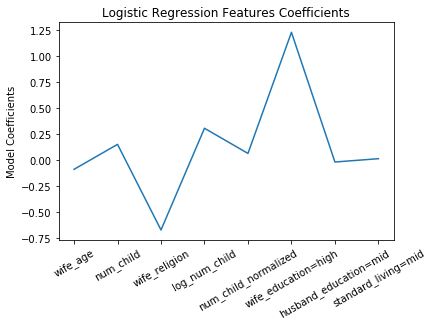

In [52]:
# line plot for coefficients
g = sns.lineplot(x=list(range(len(coeffs))), y=coeffs)
g.set_xticks(range(len(features)))
g.set_xticklabels(features)
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='center')
g.set(ylabel='Model Coefficients', 
      title="Logistic Regression Features Coefficients")
plt.show()

## Confusion Matrix

<Figure size 720x720 with 0 Axes>

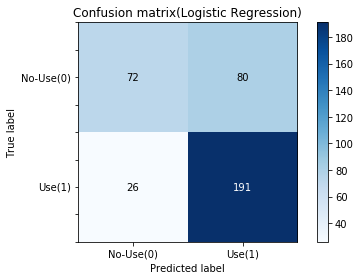

In [53]:
np.set_printoptions(precision=2)

lab_names = ["No-Use(0)", "Use(1)"]
# Plot normalized confusion matrix
plot_confusion_matrix(Y_test_lr.values, model_predicted_test, labels=lab_names,
                      title='Confusion matrix(Logistic Regression)')

plt.show()

### Result:

<Figure size 720x360 with 0 Axes>

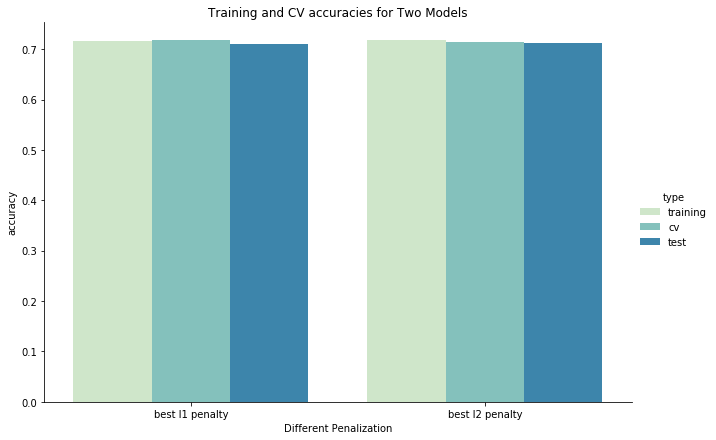

In [54]:
# accuracy plot of 
# best logistic regression with l1 penalty 
# best logistic regression with l2 penalty 
figure(figsize=(10,5))
label = ["best l1 penalty", "best l2 penalty"]
accs = pd.DataFrame({'Different Penalization': label, 
                     'training': [train_accuracy_l1,best_train_lr],
                     'cv': [cv_accuracy_l1,best_cv_lr],
                    'test':[test_accuracy_l1,best_test_lr]})

accs = pd.melt(accs, id_vars = "Different Penalization")
accs = accs.rename({"variable": "type", "value": "accuracy"}, axis = 1)

sns.catplot(x = 'Different Penalization', y='accuracy', hue = 'type',data=accs, kind='bar', 
            palette = 'GnBu', height = 6, aspect = 1.5)
plt.title("Training and CV accuracies for Two Models")
plt.show()

# KNN

In [55]:
X_train_knn, X_test_knn, Y_train_knn, Y_test_knn = train_test_split(data_trans.drop('contraceptive', axis=1),
                                                  data_trans['contraceptive'], test_size=0.25, 
                                                  random_state=seed)

print("Training Data Size:", {len(X_train_knn)})
print("Test Data Size:", {len(X_test_knn)})

Training Data Size: {1104}
Test Data Size: {369}


In [56]:
# create basic KNN classifier
knn = KNeighborsClassifier()

education_drop_cols = ['wife_education=high',
       'wife_education=low', 'wife_education=low_mid', 'wife_education=mid',
       'husband_education=high', 'husband_education=low',
       'husband_education=low_mid', 'husband_education=mid']

X_train_house = X_train_knn.drop(education_drop_cols, axis=1)
cv_accs_house = cross_validate_accuracy(knn, X_train_house, Y_train_knn)

knn = KNeighborsClassifier()
X_train_wh = X_train_knn.drop('house_hold_education', axis=1)
cv_accs_wh = cross_validate_accuracy(knn, X_train_wh, Y_train_knn)

print('Cross Validation Accuracy with `household_education`: {:0.6f}\n\
Cross Validation Accuracy with `wife_education` & `husband_education`: {:0.6f}\n'.format(
    cv_accs_house, cv_accs_wh))

Cross Validation Accuracy with `household_education`: 0.697458
Cross Validation Accuracy with `wife_education` & `husband_education`: 0.669379



There is a 2\% increase in the validation accuracy if we don't use the `household_education`. Hence, we stick with the original two features about education.

In [57]:
X_train_knn.drop(education_drop_cols, axis=1, inplace=True)
X_test_knn.drop(education_drop_cols, axis=1, inplace=True)

In [58]:
X_train_ori = X_train_knn.drop(['wife_age_mean_centered', 'wife_age_normalized'], axis=1)
cv_accs_ori = cross_validate_accuracy(knn, X_train_ori, Y_train_knn)

X_train_cen = X_train_knn.drop(['wife_age', 'wife_age_normalized'], axis=1)
cv_accs_cen = cross_validate_accuracy(knn, X_train_cen, Y_train_knn)

X_train_nor = X_train_knn.drop(['wife_age', 'wife_age_mean_centered'], axis=1)
cv_accs_nor = cross_validate_accuracy(knn, X_train_nor, Y_train_knn)

print('      Cross Validation Accuracy with `wife_age`: {:0.7f}\n\
      Cross Validation Accuracy with `wife_age_mean_centered`: {:0.7f}\n\
      Cross Validation Accuracy with `wife_age_normalized`: {:0.7f}\n'.format(
    cv_accs_ori, cv_accs_cen, cv_accs_nor))


      Cross Validation Accuracy with `wife_age`: 0.6965529
      Cross Validation Accuracy with `wife_age_mean_centered`: 0.6856684
      Cross Validation Accuracy with `wife_age_normalized`: 0.6883957



Because the normalized version outperforms other two variants, we keep `wife_age` and drop the others.

In [59]:
X_train_knn.drop('wife_age', axis=1, inplace=True)
X_test_knn.drop('wife_age', axis=1, inplace=True)

X_train_knn.drop('wife_age_normalized', axis=1, inplace=True)
X_test_knn.drop('wife_age_normalized', axis=1, inplace=True)

In [60]:
# feature selection for knn
features_rm, improved_accs_knn = remove_feature(knn, X_train_knn, Y_train_knn)

W/o `age_bins=age>=44` improved CV accuracy by 0.00271081859
W/o `house_hold_education` improved CV accuracy by 0.00452900041
W/o `husband_occupation=2` improved CV accuracy by 0.00270670506
W/o `husband_occupation=3` improved CV accuracy by 0.00723981900
W/o `husband_occupation=4` improved CV accuracy by 0.00363636364
W/o `standard_living=low_mid` improved CV accuracy by 0.01356232003


In [61]:
final_X_train_knn = X_train_knn.copy()
final_X_test_knn = X_test_knn.copy()
for f in features_rm:
    final_X_train_knn.drop(f,axis=1, inplace=True)
    final_X_test_knn.drop(f,axis=1, inplace=True)
final_X_train_knn.columns

Index(['num_child', 'wife_religion', 'wife_work', 'media_exposure',
       'age_bins=22<age<44', 'age_bins=age<= 22', 'wife_age_mean_centered',
       'log_num_child', 'num_child_normalized', 'husband_occupation=1',
       'standard_living=high', 'standard_living=low', 'standard_living=mid'],
      dtype='object')

Next, we need to tune two hyperparameters of the kNN model--- the number of neighbors $n$ and the Minkowski metric $p$. The candidates $p = 1$, which is the absolute norm, or $p= 2$, which is the Euclidean norm.

In [62]:
# Model Hyperparameters Tunning for Uniform weights
ns = list(range(1, 100))
ps = list(range(1, 4))
# dummy best model start 
best_model_knn = KNeighborsClassifier(n_neighbors=ns[0], p=ps[0], weights="uniform")
best_train_knn = 0
best_cv_knn = 0

for n in ns:
    for p in ps:
        cur_model = KNeighborsClassifier(n_neighbors=n, p=p, weights="uniform")
        cur_model.fit(final_X_train_knn, Y_train_knn)
        model_predicted_train = cur_model.predict(final_X_train_knn)
        train_accuracy = accuracy_score(Y_train_knn, model_predicted_train)
        cv_accuracy = cross_validate_accuracy(cur_model, final_X_train_knn, 
                                              Y_train_knn)
        if(cv_accuracy > best_cv_knn):
            best_cv_knn = cv_accuracy
            best_train_knn = train_accuracy
            best_model_knn = cur_model
            print("Cur model(n:{}, p:{}); Train Accuracy: {:0.4f}; CV Accuracy: {:0.4f}".format(
             n, p, train_accuracy, cv_accuracy))
        elif(cv_accuracy == best_cv_knn and 
              train_accuracy > best_train_knn):
            best_cv_knn = cv_accuracy
            best_train_knn = train_accuracy
            best_model_knn = cur_model
            print("Cur model(n:{}, p:{}); Train Accuracy: {:0.4f}; CV Accuracy: {:0.4f}".format(
             n, p, train_accuracy, cv_accuracy))

Cur model(n:1, p:1); Train Accuracy: 0.9266; CV Accuracy: 0.6585
Cur model(n:1, p:2); Train Accuracy: 0.9266; CV Accuracy: 0.6621
Cur model(n:3, p:1); Train Accuracy: 0.8243; CV Accuracy: 0.6766
Cur model(n:5, p:1); Train Accuracy: 0.7772; CV Accuracy: 0.6802
Cur model(n:5, p:2); Train Accuracy: 0.7754; CV Accuracy: 0.6848
Cur model(n:7, p:2); Train Accuracy: 0.7545; CV Accuracy: 0.6929
Cur model(n:9, p:1); Train Accuracy: 0.7500; CV Accuracy: 0.6974
Cur model(n:11, p:2); Train Accuracy: 0.7455; CV Accuracy: 0.6983
Cur model(n:13, p:3); Train Accuracy: 0.7274; CV Accuracy: 0.6992
Cur model(n:15, p:1); Train Accuracy: 0.7301; CV Accuracy: 0.7011
Cur model(n:21, p:1); Train Accuracy: 0.7219; CV Accuracy: 0.7020
Cur model(n:27, p:2); Train Accuracy: 0.7165; CV Accuracy: 0.7083
Cur model(n:28, p:3); Train Accuracy: 0.7174; CV Accuracy: 0.7119


In [63]:
best_test_knn = best_model_knn.score(final_X_test_knn, Y_test_knn)
print(f"Train accuracy of kNN with Uniform Weights is: {best_train_knn:.4f}")
print(f"CV accuracy of kNN with Uniform Weights is: {best_cv_knn:.4f}")
print(f"Test accuracy of kNN with Uniform Weights is: {best_test_knn:.4f}")

Train accuracy of kNN with Uniform Weights is: 0.7174
CV accuracy of kNN with Uniform Weights is: 0.7119
Test accuracy of kNN with Uniform Weights is: 0.7019


In [64]:
best_model_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=28, p=3,
           weights='uniform')

The optimal kNN model uses 28 neighbors and $l_3$ distance. Finally, we need to decide the weights for each neighbor of a given query point. Should we assign uniform weights? Or should we allocate more weights to neighbors closer to the query point.

In [65]:
# this is the best KNN model with `distance` weights
distance_knn = KNeighborsClassifier(n_neighbors=28, p=3, weights="distance") 
distance_knn.fit(final_X_train_knn, Y_train_knn)

train_accuracy_distance = distance_knn.score(final_X_train_knn,Y_train_knn)
cv_accuracy_distance = cross_validate_accuracy(distance_knn, final_X_train_knn, Y_train_knn)
test_accuracy_distance = distance_knn.score(final_X_test_knn,Y_test_knn)
print(f"Train accuracy of kNN with Distance Weights is: {train_accuracy_distance:.4f}")
print(f"CV accuracy of kNN with Distance Weights is: {cv_accuracy_distance:.4f}")
print(f"Test accuracy of kNN with Distance Weights is: {test_accuracy_distance:.4f}")

Train accuracy of kNN with Distance Weights is: 0.9330
CV accuracy of kNN with Distance Weights is: 0.6784
Test accuracy of kNN with Distance Weights is: 0.6694


### Result:

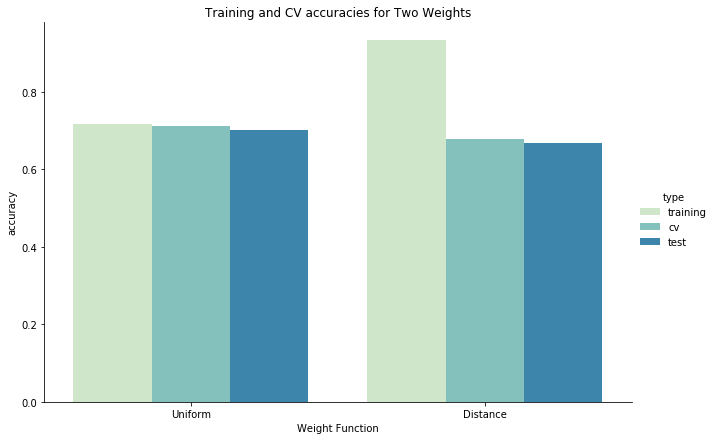

In [66]:
label = ["Uniform", "Distance"]
accs = pd.DataFrame({'Weight Function': label, 
                     'training': [best_train_knn, train_accuracy_distance],
                     'cv': [best_cv_knn, cv_accuracy_distance],
                    'test':[best_test_knn,test_accuracy_distance]})

accs = pd.melt(accs, id_vars = "Weight Function")
accs = accs.rename({"variable": "type", "value": "accuracy"}, axis = 1)

sns.catplot(x = 'Weight Function', y='accuracy', hue = 'type',data=accs, kind='bar', 
            palette = 'GnBu', height = 6, aspect = 1.5)
plt.title("Training and CV accuracies for Two Weights")
plt.show()

## Confusion Matrix

<Figure size 720x720 with 0 Axes>

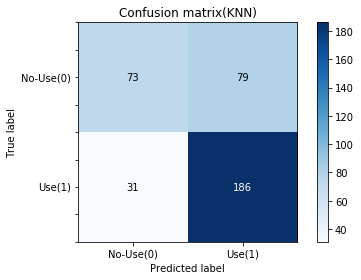

In [67]:
# Plot normalized confusion matrix
lab_names = ["No-Use(0)", "Use(1)"]
predicted_test_knn = best_model_knn.predict(final_X_test_knn)
plot_confusion_matrix(Y_test_knn.values,predicted_test_knn, 
                      labels=lab_names,
                      title='Confusion matrix(KNN)')

plt.show()

# Random Forest
In this section, we will use a random forest model to predict whether a family uses contraceptive or not. We will first train a basic model with default parameters and all features. Next, we conduct analysis on the remaining features and utilize feature engineering to further improve our results. Then, we will filter out features that are harmful to our predictions. Finally, we tune a set of parameters from the ensemble.RandomForestClassifier class to achieve the optimal result. In the end of section, we include a summary and interpretation of our result

## I. Train a basic model
We first train a basic model with all features available and default parameters.

We need to prepare data by converting the contraceptive column into labels. A family uses a contraceptive, regardless whether it's short-term or long-term, has a label of 1, and a family that doesn't use a contraceptive has a label of 0.
Then, we split the data into training set and test set with a ratio of 3:1.

In [68]:
train, test = train_test_split(data, test_size=0.25, random_state=seed)
X_train = train.drop("contraceptive", axis = 1)
X_test = test.drop("contraceptive", axis = 1)
y_train = train["contraceptive"]
y_test = test["contraceptive"]
r = 234 #random state

In [69]:
def get_accuracy(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train and y_train, and return the score of predictions on X_test and y_test.
    """
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

Train the first random forest classifier model. Calculate the cross validation accuracy for feature selection. Calculate and store the training accuracy in addition to the cross validation accuracy for summary and comparison at the end. 

(We specify n_estimators here to suppress warning, and we choose 20 because this is the number used in lab 11.)

In [70]:
model = ensemble.RandomForestClassifier(n_estimators = 20, random_state = r)
feature_set_cv_accuracies = cross_validate_accuracy(model, X_train, y_train)
training_accuracy_basic = get_accuracy(model, X_train, y_train, X_train, y_train)
cv_basic = feature_set_cv_accuracies
print ("Basic model has cross validation accuracy: " + str(feature_set_cv_accuracies))
print("Basic model has training accuracy: " + str(training_accuracy_basic))

Basic model has cross validation accuracy: 0.6675524475524476
Basic model has training accuracy: 0.9755434782608695


In [71]:
features = list(X_train.columns)
features

['wife_age',
 'wife_education',
 'husband_education',
 'num_child',
 'wife_religion',
 'wife_work',
 'husband_occupation',
 'standard_living',
 'media_exposure']

## II. Feature engineering

In this section, we need to improve our current features to make better predictions. In this section, we will focus on two set of features. The first set includes wife_education and husband_education, and the second set involves num_child.

### 1. Education of a household

In the original dataset, we have two columns, wife education and husband education. During our EDA stage, we have found out that both wife education and education of a household can be good indicators of whehter a family uses contraceptives. Since using contraceptives should be related to the entire family, we would like to see if the total education of a household can be a feature to improve our model performance.

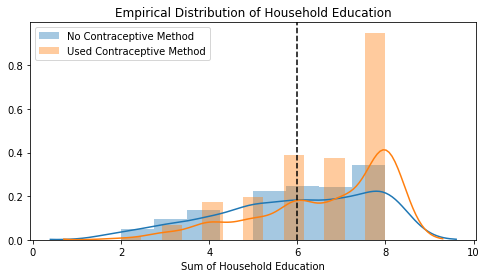

In [72]:
training_data = X_train.copy()
training_data["contraceptive"] = y_train
training_data["household_education_sum"] = training_data["wife_education"] + training_data["husband_education"]
plt.figure(figsize=(8, 4))
sns.distplot(training_data.loc[(training_data["contraceptive"]==0) , "household_education_sum"])
sns.distplot(training_data.loc[(training_data["contraceptive"]==1) , "household_education_sum"])
plt.xlabel("Sum of Household Education")
plt.title("Empirical Distribution of Household Education")
plt.legend(labels=["No Contraceptive Method", "Used Contraceptive Method"]) 
plt.axvline(6, color='k', linestyle='dashed')
plt.show();

This plot shows that there is a clear threshold at sum of household education equals 6. When the sum of household education is less than 6, the family is more likely to use no contraceptives. When the sum of houshold is at least 6, the family is more likely to use contraceptives.
As a result, a feature indicating the education level of a household may improve our model performance.

#### Numerical values and boolean bins

We can either use the above threshold of 6 to construct boolean bins as a new feature, or just add the sum of wife and husband education levels as a new feature. First, we should check that whether adding each of the two features into our existing dataset improves the model performance. If so, we should add the corresponding column to the feature set. Although the two features might be redundant when both are added, we can eliminate the harmful results of the redundancy through feature filtering in the next step.

In [73]:
X_train["household_education"] = (X_train["wife_education"] + X_train["husband_education"] >= 6).astype(int)
X_test["household_education"] = (X_test["wife_education"] + X_test["husband_education"] >= 6).astype(int)
X_train["household_education_sum"] = X_train["wife_education"] + X_train["husband_education"]
X_test["household_education_sum"] = X_test["wife_education"] + X_test["husband_education"]

In [74]:
features_sum = features[:]
features_sum.append("household_education_sum")
print("Cross validation accuracy with household_education_sum: " 
      + str(cross_validate_accuracy(model, X_train[features_sum], y_train)))

Cross validation accuracy with household_education_sum: 0.6820567667626491


In [75]:
features_bool = features[:]
features_bool.append("household_education")
print("Cross validation accuracy with household_education: " + 
      str(cross_validate_accuracy(model, X_train[features_bool], y_train)))

Cross validation accuracy with household_education: 0.6612093788564376


Since household_education_sum achieves an improvement in cross validation accuracy, we may add it into our feature set. It shows that the combined information of household education is indeed helpful in predicting whether a family uses contraceptives or not.

### 2. Log number of child

In our EDA stage, we have shown that the number of children is right skewed. Taking a log of the number of children may make the dirstibution closer to a normal distribution and thus leads to a better feature.

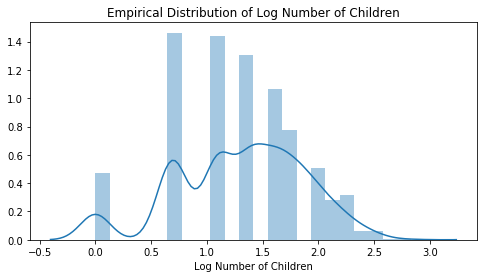

In [76]:
plt.figure(figsize=(8, 4))
training_data["log_num_child"] = np.log(training_data["num_child"] + 1)
sns.distplot(training_data["log_num_child"])
plt.xlabel("Log Number of Children")
plt.title("Empirical Distribution of Log Number of Children")
plt.show();

Each distribution in the resulting plot is indeed more symmetric about the global maximum and closer to a normal distribution. Now we add log_num_child and compare it with our basic model.

In [77]:
X_train["log_num_child"] = np.log(X_train["num_child"] + 1)
X_test["log_num_child"] = np.log(X_test["num_child"] + 1)

In [78]:
features_log = features[:]
features_log.append("log_num_child")
print("Cross validation accuracy with log_num_child: " + str(cross_validate_accuracy(model, X_train[features_log], y_train)))

Cross validation accuracy with log_num_child: 0.6883628136569312


Since the cross validation accuracy with log_num_child is more than than the cross validation accuracy from our original model, we would add the log_num_child feature to our feature set.

### Feature engineering results

This is our updated set of features.

In [79]:
features.append("household_education_sum")
features.append("log_num_child")
features

['wife_age',
 'wife_education',
 'husband_education',
 'num_child',
 'wife_religion',
 'wife_work',
 'husband_occupation',
 'standard_living',
 'media_exposure',
 'household_education_sum',
 'log_num_child']

Re-calculate training accuracy and cross validation accuracy with our new feature set.

In [80]:
feature_set_cv_accuracies = cross_validate_accuracy(model, X_train[features], y_train)
training_accuracy_feature_engineering = get_accuracy(model, X_train[features], y_train, X_train[features], y_train)
cv_feature_engineering = feature_set_cv_accuracies
print ("Feature engineered model has cross validation accuracy: " + str(cv_feature_engineering))
print("Feature engineered model has training accuracy: " + str(training_accuracy_feature_engineering))

Feature engineered model has cross validation accuracy: 0.6802385849444673
Feature engineered model has training accuracy: 0.9755434782608695


## III. Feature selection

Among all features, some features can be harmful to the prediction process. In this step, we will train models without a selected column. If the cross validation accuracy improves, it shows that the selected column contributes negatively to our prediction and should be removed.

Below is the full set of features.

In [81]:
features

['wife_age',
 'wife_education',
 'husband_education',
 'num_child',
 'wife_religion',
 'wife_work',
 'husband_occupation',
 'standard_living',
 'media_exposure',
 'household_education_sum',
 'log_num_child']

Evaluate features as followed. For each iteration:
1. Train a model for each set of features such that exactly one feature is not used.
2. If average cross validation accuracy > original cross validation accuracy, and average cross validation accuracy > existing average cross validation accuracy, update the feature to be removed. 
3. Remove the candidtate feature if exists. If there is none, we are done with filtering

In [82]:
def filter_feature(features, X_train, y_train, feature_set_cv_accuracies):
    removal_candidate = None
    removal_cv = feature_set_cv_accuracies
    remove = False
    for f in features:
        X_train_cur = X_train.copy()
        X_train_cur = X_train_cur.drop(f, axis = 1)
        cv_accuracy = cross_validate_accuracy(model, X_train_cur, y_train)
        if (cv_accuracy > feature_set_cv_accuracies and cv_accuracy > removal_cv):
            removal_cv = cv_accuracy
            removal_candidate = f
            remove = True
    return (removal_candidate, removal_cv, remove)

In [83]:
remove = True
counter = 1
features_experiment = features[:]
while remove and len(features_experiment) > 0:
    print("Iteration " + str(counter))
    counter += 1
    remove_feature, remove_cv, remove = filter_feature(features_experiment, X_train[features_experiment], y_train, feature_set_cv_accuracies)
    if remove:
        print("We should remove " + remove_feature)
        print("CV accuracy is " + str(remove_cv) + ", improved " + str(remove_cv - feature_set_cv_accuracies))
        feature_set_cv_accuracies = remove_cv
        features_experiment.remove(remove_feature)
    else:
        print("We are done with feature filtering")

Iteration 1
We should remove media_exposure
CV accuracy is 0.6965364047716989, improved 0.016297819827231552
Iteration 2
We should remove husband_education
CV accuracy is 0.7019539284245168, improved 0.0054175236528178905
Iteration 3
We should remove wife_religion
CV accuracy is 0.7019621554915674, improved 8.2270670506146e-06
Iteration 4
We are done with feature filtering


We have removed any feature that contributes negatively to the model performance.

Here is our updated set of features:

In [84]:
features = features_experiment[:]
features

['wife_age',
 'wife_education',
 'num_child',
 'wife_work',
 'husband_occupation',
 'standard_living',
 'household_education_sum',
 'log_num_child']

We now recalculate training error and cross validation error for comparison and analysis.

In [85]:
training_accuracy_filtered = get_accuracy(model, X_train[features], y_train, X_train[features], y_train)
cv_filtered = feature_set_cv_accuracies
print ("Feature filtered model has cross validation accuracy: " + str(cv_filtered))
print("Feature filtered model has training accuracy: " + str(training_accuracy_filtered))

Feature filtered model has cross validation accuracy: 0.7019621554915674
Feature filtered model has training accuracy: 0.9755434782608695


## 	IV. Parameter tuning

As we have finalized our features, we should tune the parameters of the random forest classifier to improve cross validation accuracy, meanwhile reducing overfitting. We will be focusing on two parameters: number of estimators and max depth.

First, we calculate the baseline cross validation accuracy to make sure our final result is improved. 

In [86]:
# Use cross validation to tune random forest parameters
print("Baseline cross validation accuracy: " + str(cv_filtered))

Baseline cross validation accuracy: 0.7019621554915674


### Tune number of estimators

In order to find our the best number of estimators, we fit a model for various numbers of estimators, holding the other parameters and features constant.

In [87]:
# Tune number of estimators
num_estimators = np.arange(5, 105, 5)
cv_accuracies = []
X_train_columns = X_train[features]
for n in num_estimators:
    model = ensemble.RandomForestClassifier(n_estimators = n, random_state = r)
    cv_accuracies.append(cross_validate_accuracy(model, X_train_columns, y_train))

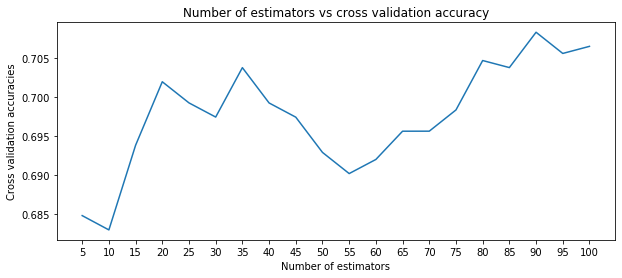

In [88]:
plt.figure(figsize = (10, 4))
plt.plot(num_estimators, cv_accuracies)
plt.xticks(num_estimators)
plt.title("Number of estimators vs cross validation accuracy")
plt.xlabel("Number of estimators")
plt.ylabel("Cross validation accuracies")
plt.show();

The graph shows that there is a local and global maxima at n = 90.

In [89]:
estimator = 90

### Tune max depth

Next, we tune the max depth of each decision. This parameter is mainly used to reduce overfitting.

In [90]:
# Tune max depth
depth = np.arange(5, 105, 10)
cv_accuracies = []
X_train_columns = X_train[features]
for n in depth:
    model = ensemble.RandomForestClassifier(n_estimators = estimator, max_depth = n, random_state = r)
    cv_accuracies.append(cross_validate_accuracy(model, X_train_columns, y_train))

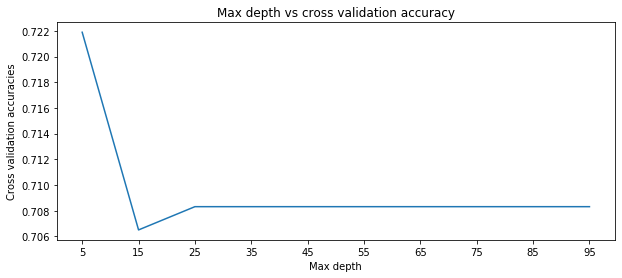

In [91]:
plt.figure(figsize = (10, 4))
plt.plot(depth, cv_accuracies)
plt.xticks(depth)
plt.title("Max depth vs cross validation accuracy")
plt.xlabel("Max depth")
plt.ylabel("Cross validation accuracies");

From this plot, we observe that the best cross validation error occurs between 1 and 15. We should closely examine this range to tune the max_depth parameter at a finer granularity.

In [92]:
# Tune max depth from 1 to 15
depth = np.linspace(1, 15, 15)
cv_accuracies = []
X_train_columns = X_train[['num_child', 'wife_age', "household_education"]]
for n in depth:
    model = ensemble.RandomForestClassifier(n_estimators = estimator, max_depth = n, random_state = r)
    cv_accuracies.append(cross_validate_accuracy(model, X_train_columns, y_train))

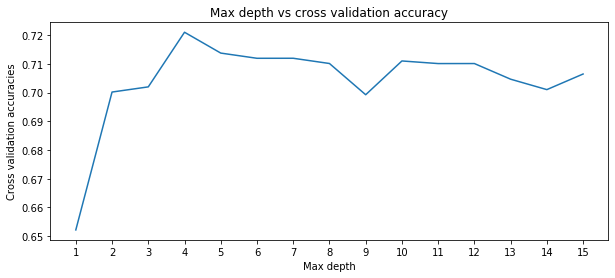

In [93]:
plt.figure(figsize = (10, 4))
plt.plot(depth, cv_accuracies)
plt.xticks(depth)
plt.title("Max depth vs cross validation accuracy")
plt.xlabel("Max depth")
plt.ylabel("Cross validation accuracies");

We can observe that at max_depth = 4, the cross validation accuracy achieves a local maxima as well as a global maxima. As a result, we should use 4 for the max_depth parameter.

In [94]:
best_depth = 4

### Results after tuning

Now, we have tuned our model according to cross validation accuracy. We should calculate and store the cross validation accuracy and training accuracy.

In [95]:
model = ensemble.RandomForestClassifier(n_estimators = estimator, max_depth = best_depth, random_state = r)
cv_final = cross_validate_accuracy(model, X_train_columns, y_train)
training_final = get_accuracy(model, X_train[features], y_train, X_train[features], y_train)
print ("Final model has cross validation accuracy: " + str(cv_final))
print("Final filtered model has training accuracy: " + str(training_final))

Final model has cross validation accuracy: 0.7210283833813247
Final filtered model has training accuracy: 0.7472826086956522


As expected, the cross validation accuracy has increased, and the training accuracy has decreased to a similar level as the croess validation accuracy, implying that the parameter tuning has improved the model performance and that we have greatly reduced overfitting.

## V. Summary and interpretation

First, we should look at the developments of training accuracies and cross validation accuracies along the way.

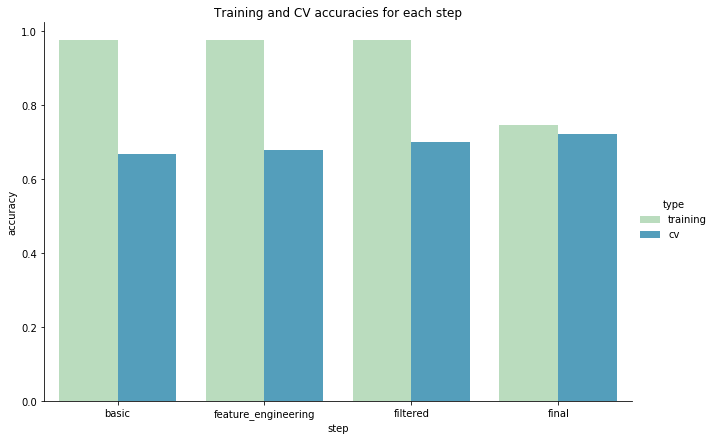

In [96]:
training_accuracies = [training_accuracy_basic, training_accuracy_feature_engineering, 
                       training_accuracy_filtered, training_final]
cv_accuracies = [cv_basic, cv_feature_engineering, cv_filtered, cv_final]
label = ["basic", "feature_engineering", "filtered", "final"]
accuracies = pd.DataFrame(data={'step': label, 'training': training_accuracies,'cv': cv_accuracies})

accuracies = pd.melt(accuracies, id_vars = "step")
accuracies = accuracies.rename({"variable": "type", "value": "accuracy"}, axis = 1)

sns.catplot(x = 'step', y='accuracy', hue = 'type',data=accuracies, kind='bar', palette = 'GnBu', height = 6, aspect = 1.5)
plt.title("Training and CV accuracies for each step")
plt.show()

For each step, the cross validation accuracy increases, implyinh that each step of our model optmization has effectively improved our model to make better predictions. In addition, among all the steps, parameter tuning has most effectively reduced overfitting.

Since we have finalized our model, we can take a look at the testing accuracy.

In [97]:
testing_accuracy = get_accuracy(model, X_train[features], y_train, X_test[features], y_test)
testing_accuracy

0.7235772357723578

This testing accuracy tells us how well our model will perform on unknown data.

### Confusion Matrix

<Figure size 720x720 with 0 Axes>

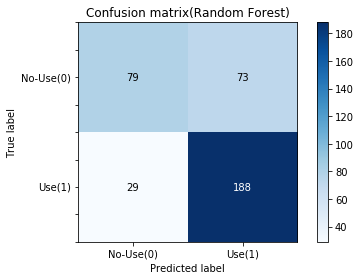

In [98]:
# Plot normalized confusion matrix
predicted_test_rf = model.predict(X_test[features])
lab_names = ["No-Use(0)", "Use(1)"]
plot_confusion_matrix(y_test.values,predicted_test_rf, labels=lab_names,
                      title='Confusion matrix(Random Forest)')

plt.show()

# Model Comparison

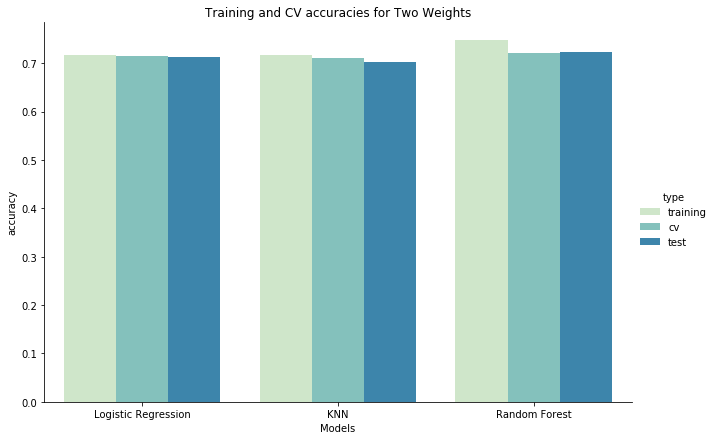

In [127]:
label = ["Logistic Regression", "KNN", "Random Forest"]
accs = pd.DataFrame({'Models': label, 
                     'training': [best_train_lr, best_train_knn, training_final],
                     'cv': [best_cv_lr, best_cv_knn, cv_final],
                    'test':[best_test_lr,best_test_knn,testing_accuracy]})

accs = pd.melt(accs, id_vars = "Models")
accs = accs.rename({"variable": "type", "value": "accuracy"}, axis = 1)

sns.catplot(x = 'Models', y='accuracy', hue = 'type',data=accs, kind='bar', 
            palette = 'GnBu', height = 6, aspect = 1.5)
plt.title("Training and CV accuracies for Two Weights")
plt.show()

# Suprising Discovery

In [100]:
import statsmodels.api as sm
duration_df = ori_data.loc[ori_data["contraceptive"] > 1, :]
duration_X = duration_df.drop("contraceptive", axis=1)
duration_y = duration_df[["contraceptive"]].replace({2: 0, 3: 1})

logit = sm.Logit(duration_y, duration_X).fit()
logit.summary2(alpha=0.05)

Optimization terminated successfully.
         Current function value: 0.610916
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:               Logit            Pseudo R-squared: 0.089     
Dependent Variable:  contraceptive    AIC:              1049.2263 
Date:                2020-05-13 22:55 BIC:              1091.8696 
No. Observations:    844              Log-Likelihood:   -515.61   
Df Model:            8                LL-Null:          -566.10   
Df Residuals:        835              LLR p-value:      2.6882e-18
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      5.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
wife_age           -0.0438   0.0131 -3.3391 0.0008 -0.0695 -0.0181
wife_education     -0.3922   0.1124 -3.4905 0.0005 -0.6125 -0.1720
husband_education   0.4137   0.1296  3.1925 0.0014  0.1597  0.6677
num_child           0.0130   0.0490  0.2655 0.7906 -0.0830  0.1091
wife_religion       0.5113   0.1842  2.7754 0.0055  0.1502  0.8723
wife_work           0.1926   0.1725  1.1170 0.2640 -0.1454  0.5306
husband_occupation  0.4882   0.0773  6.3129 0.0000  0.3367  0.6398
standard_living    -0.0025   0.0952 -0.0265 0.9788 -0.1892  0.1842
media_exposure      0.1159   0.4081  0.2840 0.7764 -0.6840  0.9158
==================================================================

"""